In [1]:
!pip install bt

In [2]:
!pip install yfinance

In [4]:
import bt
import yfinance as yf


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [6]:
def cdi_acumulado(data_inicio, data_fim):
  cdi = consulta_bc(12)
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [7]:
data_inicio = '2015-01-02'
data_fim =    '2019-12-31'

In [8]:
cdi = cdi_acumulado(data_inicio=data_inicio, data_fim=data_fim)


In [9]:
tickers_carteira = ['BOVA11.SA', 'SMAL11.SA']

In [11]:
carteira = yf.download(tickers_carteira, start=data_inicio, end=data_fim)['Close']

[*********************100%***********************]  2 of 2 completed


In [12]:
carteira['renda_fixa'] = cdi
carteira.dropna(inplace=True)

In [13]:
carteira.columns = carteira.columns.str.rstrip('.SA')

In [14]:
carteira

Ticker,BOVA11,SMAL11,renda_fixa
Date,,,
2015-01-02,47.259998,52.020000,1.000000
2015-01-05,46.320000,50.549999,1.000869
2015-01-06,46.580002,50.000000,1.001304
2015-01-07,48.150002,51.250000,1.001739
2015-01-08,48.509998,52.000000,1.002175
...,...,...,...
2019-12-20,110.839996,133.199997,1.598532
2019-12-23,111.669998,134.580002,1.598805
2019-12-26,112.809998,136.809998,1.599352


In [15]:
rebalanceamento = bt.Strategy('rebalanceamento',
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 bt.algos.SelectAll(),
                 bt.algos.CapitalFlow(10000),
                 bt.algos.WeighSpecified(BOVA11=0.4, SMAL11=0.4, renda_fixa=0.2),
                 bt.algos.Rebalance()])

In [16]:
buy_hold = bt.Strategy('Buy&Hold',
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     bt.algos.Rebalance()]
                    )

In [17]:
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira[['BOVA11', 'SMAL11']])

In [ ]:
resultados = bt.run(bt1, bt2)

/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [ ]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2015-01-01         2015-01-01
End                  2019-12-30         2019-12-30
Risk-free rate       0.00%              0.00%

Total Return         132.03%            148.81%
Daily Sharpe         1.12               1.00
Daily Sortino        1.86               1.66
CAGR                 18.36%             20.02%
Max Drawdown         -26.66%            -34.15%
Calmar Ratio         0.69               0.59

MTD                  7.74%              9.66%
3m                   12.55%             15.58%
6m                   18.71%             22.98%
YTD                  35.45%             43.68%
1Y                   35.45%             43.68%
3Y (ann.)            25.78%             30.26%
5Y (ann.)            18.36%             20.02%
10Y (ann.)           -                  -
Since Incep. (ann.)  18.36%             20.02%

Daily Sharpe         1.12               1.00
Daily Sor

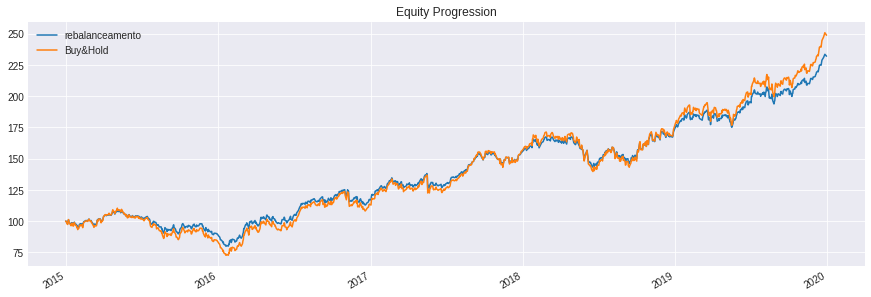

In [ ]:
resultados.plot();

In [ ]:
resultados.get_transactions()

price  quantity
Date       Security                        
2015-01-02 BOVA11       47.259998    8548.0
           SMAL11       52.020000    7766.0
           renda_fixa    1.000000  202000.0
2015-01-30 BOVA11       45.610001     -67.0
           SMAL11       46.790001     502.0
...                           ...       ...
2019-10-31 SMAL11      115.570000     -17.0
           renda_fixa    1.588157    6848.0
2019-11-29 BOVA11      104.349998     200.0
           SMAL11      121.199997    -212.0
           renda_fixa    1.594198    9262.0

[179 rows x 2 columns]

In [ ]:
resultados.get_security_weights()

,BOVA11,SMAL11,renda_fixa
2015-01-01,0.000000,0.000000,0.000000
2015-01-02,0.399979,0.399987,0.200000
2015-01-05,0.399650,0.396247,0.204068
2015-01-06,0.402691,0.392713,0.204562
2015-01-07,0.406714,0.393296,0.199956
...,...,...,...
2019-12-20,0.398907,0.412742,0.188300
2019-12-23,0.398983,0.413997,0.186968
2019-12-26,0.398672,0.416280,0.184998
2019-12-27,0.397127,0.417459,0.185364


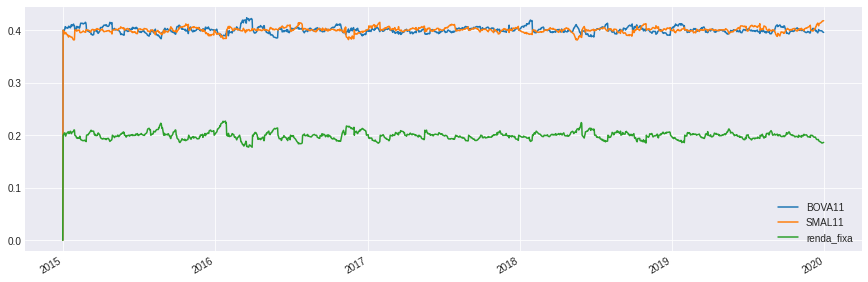

In [ ]:
resultados.plot_security_weights()